# Tutorial 2: 10x human lymph node data Integartion

To evaluate the effectiveness of SMART on real-world data, we applied SMART and several comparison methods to a co-detected transcriptome and proteome dataset from human lymph node section A1, generated using the 10x Visium Spatial Platform. Hematoxylin and eosin (H&E)-based annotations were used as the ground truth. The outer region of the tissue is primarily composed of pericapsular adipose tissue and the capsule, while the inner region includes the cortex, medullary sinuses, and medullary cords.

The raw data can be downloaded from: https://drive.google.com/drive/folders/1pIK6hZCvqHNh0K94-Lgy-CTyfixEUftQ?usp=drive_link.

## Load packages

In [9]:
import os
import torch
import pandas as pd
import scanpy as sc
import warnings
from muon import prot as pt
from muon import atac as ac
from smart.train import train_SMART
from smart.utils import set_seed
from smart.utils import pca
from smart.utils import Cal_Spatial_Net
from smart.utils import clustering
from smart.utils import Mutual_Nearest_Neighbors
import matplotlib.pyplot as plt

set_seed(2024)

# warnings.filterwarnings('ignore')
# Environment configuration. SMART pacakge can be implemented with either CPU or GPU. GPU acceleration is highly recommend for imporoved efficiency.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# the location of R, which is required for the 'mclust' algorithm. Please replace the path below with local R installation path, use the command `R RHOME` to find the path.
os.environ['R_HOME'] = '/public/home/cit_wlhuang/.conda/envs/smart/lib/R'

## Load data

In [2]:
# read data
file_fold = '../SMART-main_orignal/datasets/10X_human_lymph_node/A1/'  #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + 'adata_ADT.h5ad')


adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()


adata_omics1.obs["anno"]=pd.read_csv(file_fold+"annotation.csv",index_col=0)["manual-anno"]

adata_omics1,adata_omics2

/public/home/cit_wlhuang/.conda/envs/smart-copy/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/public/home/cit_wlhuang/.conda/envs/smart-copy/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(AnnData object with n_obs × n_vars = 3484 × 18085
     obs: 'anno'
     var: 'gene_ids', 'feature_types', 'genome'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 3484 × 31
     var: 'gene_ids', 'feature_types', 'genome'
     obsm: 'spatial')

## Data pre-processing

In [3]:
# RNA
sc.pp.filter_genes(adata_omics1, min_cells=10)

sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
sc.pp.scale(adata_omics1)

adata_omics1_high = adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=30)

# Protein
adata_omics2 = adata_omics2[adata_omics1.obs_names].copy() 
pt.pp.clr(adata_omics2)
sc.pp.scale(adata_omics2)
adata_omics2.obsm['feat'] = pca(adata_omics2, n_comps=30)

/public/home/cit_wlhuang/.conda/envs/smart-copy/lib/python3.9/site-packages/muon/_prot/preproc.py:219: UserWarning: adata.X is sparse but not in CSC format. Converting to CSC.
  warn("adata.X is sparse but not in CSC format. Converting to CSC.")


## Spatial neighbour graph construction

In [4]:
Cal_Spatial_Net(adata_omics1, model="KNN", n_neighbors=6)
Cal_Spatial_Net(adata_omics2, model="KNN", n_neighbors=6)

The graph contains 20904 edges, 3484 cells.
6.0000 neighbors per cell on average.
The graph contains 20904 edges, 3484 cells.
6.0000 neighbors per cell on average.


## MNN triplet samples calculation

In [5]:
adata_list=[adata_omics1,adata_omics2]
x = [torch.FloatTensor(adata.obsm["feat"]).to(device) for adata in adata_list]
edges =[torch.LongTensor(adata.uns["edgeList"]).to(device) for adata in adata_list ]
triplet_samples_list = [Mutual_Nearest_Neighbors(adata, key="feat", n_nearest_neighbors=3,farthest_ratio=0.6) for adata in adata_list]

Distances calculation completed!
The data using feature 'feat' contains 2732 mnn_anchors
Distances calculation completed!
The data using feature 'feat' contains 3358 mnn_anchors


## Model training

In [6]:
model=train_SMART(features=x,
            edges=edges,
            triplet_samples_list=triplet_samples_list,
            weights=[1,1,1,1],
            emb_dim=64, 
            n_epochs=300,
            lr=5e-3,
            weight_decay=1e-6,
            device = device,
            window_size=10,
            slope=1e-4)

adata_omics1.obsm["SMART"]=model(x, edges)[0].cpu().detach().numpy()


 70%|██████▉   | 209/300 [00:12<00:05, 16.48it/s]

Stopping for flat trend


## Clustering

In [10]:
tool = 'mclust'  # mclust, leiden, and louvain
clustering(adata_omics1, key='SMART', add_key='SMART', n_clusters=7, method=tool, use_pca=True)
ari = adjusted_rand_score(adata_omics1.obs['anno'], adata_omics1.obs['SMART'])
print(ari)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


NameError: name 'adjusted_rand_score' is not defined

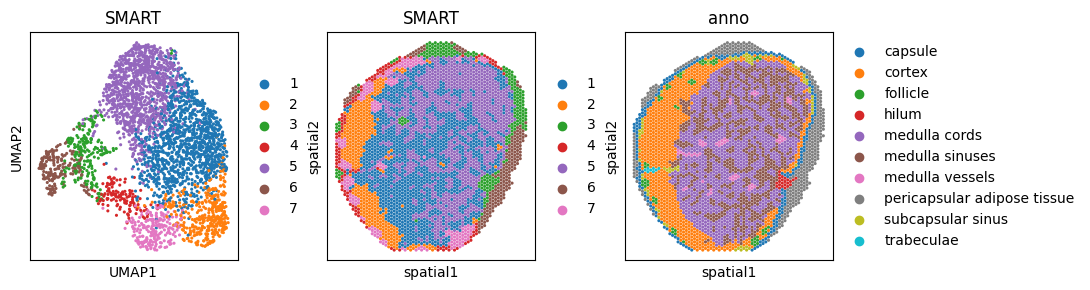

In [ ]:
fig, ax_list = plt.subplots(1, 3, figsize=(11, 3))
sc.pp.neighbors(adata_omics1, use_rep='SMART', n_neighbors=10)
sc.tl.umap(adata_omics1)

sc.pl.umap(adata_omics1, color='SMART', ax=ax_list[0], title='SMART', s=20, show=False)
sc.pl.embedding(adata_omics1, basis='spatial', color='SMART', ax=ax_list[1], title='SMART', s=20, show=False)
sc.pl.embedding(adata_omics1, basis='spatial', color='anno', ax=ax_list[2], title='anno', s=20, show=False)
plt.tight_layout(w_pad=0.3)
plt.show()